# Module 4 - Exploring Image Generation with **Amazon Nova Canvas**

---

In this hands-on session, we'll explore the powerful capabilities of Amazon Nova Canvas to create compelling visual ads for Octank, a premium dog food company.

---

### Introduction
In this notebook, you'll explore Amazon Nova Canvas, a state-of-the-art image generation model that creates high-quality, photorealistic visuals from text prompts. Nova Canvas supports advanced features such as text-to-image generation, inpainting, outpainting, image variation, and subject consistency. These capabilities make it a powerful tool for applications like product visualization, creative design, and content generation—enabling businesses to produce studio-quality images at scale, accelerate content workflows, and enhance customer experiences with highly tailored visuals.

### Use Case
Octank is launching a new dog food line and wants to create various visual assets:
- Generate an initial product package design
- Create variations of the package design, including a oil-painting style version
- Design a special promotional package using specific brand colors
- Produce a professional-looking ad with the product in a kitchen setting
- Isolate the product image for use in various marketing materials

### Lab Objectives
By the end of this notebook lab, you will:
- Understand the key features of Amazon Nova Canvas
- Learn how to use these features for a real-world marketing scenario
- Gain hands-on experience with the Amazon Bedrock API for image generation tasks

## 1. Setup

### 1.1 Import Libraries and Init Clients

In [1]:
# Built-in libraries
import base64
import io
import json
import os
import sys

# External dependencies
import boto3
import botocore
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Set up Bedrock client
boto3_bedrock = boto3.client('bedrock-runtime')

## 1.2 Implement Helper Functions

The following ultilty function visualizes generated images alongside optional reference images. It's essential for displaying and comparing the results of image generation tasks, allowing you to easily see the input, output, and any relevant color information in a single, organized plot.

In [2]:
# Utility function: Define plot function
def plot_images(base_images, prompt=None, seed=None, ref_image_path=None, color_codes=None, original_title=None, processed_title=None):
    if ref_image_path and color_codes:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        num_subplots = 3
    elif ref_image_path or color_codes:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        num_subplots = 2
    else:
        fig, axes = plt.subplots(1, 1, figsize=(6, 5))
        num_subplots = 1
    
    axes = np.array(axes).ravel() 
    
    current_subplot = 0
    
    if color_codes:
        num_colors = len(color_codes)
        color_width = 0.8 / num_colors
        for i, color_code in enumerate(color_codes):
            x = i * color_width
            rect = plt.Rectangle((x, 0), color_width, 1, facecolor=f'{color_code}', edgecolor='white')
            axes[current_subplot].add_patch(rect)
        axes[current_subplot].set_xlim(0, 0.8)
        axes[current_subplot].set_ylim(0, 1)
        axes[current_subplot].set_title('Color Codes')
        axes[current_subplot].axis('off')
        current_subplot += 1
    
    if ref_image_path:
        reference_image = Image.open(ref_image_path)
        max_size = (512, 512)
        reference_image.thumbnail(max_size)
        axes[current_subplot].imshow(np.array(reference_image))
        axes[current_subplot].set_title(original_title or 'Reference Image')
        axes[current_subplot].axis('off')
        current_subplot += 1
    
    axes[current_subplot].imshow(np.array(base_images[0]))
    if processed_title:
        axes[current_subplot].set_title(processed_title)
    elif ref_image_path and seed is not None:
        axes[current_subplot].set_title(f'Image Generated Based on Reference\nSeed: {seed}')
    elif seed is not None:
        axes[current_subplot].set_title(f'Image Generated\nSeed: {seed}')
    else:
        axes[current_subplot].set_title('Processed Image')
    axes[current_subplot].axis('off')
    
    if prompt:
        print(f"Prompt: {prompt}\n")
    
    plt.tight_layout()
    plt.show()

In [3]:
def save_image(base64_image, output_file):
    with open(output_file, 'wb') as file:
        file.write(base64.b64decode(base64_image))

## 2. Use Cases Implementation

### 2.1 Example: Text to Image


#### Scenario
Octank wants to generate an initial product package design based on a text description.

#### Parameters
1. **prompt**: Describes the desired image
2. **negative_prompts**: Specifies elements to avoid in the image
3. **seed**: For reproducibility


In [4]:
# Define the prompt
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank."
negative_prompts = "poorly rendered, poor background details, poor packet details, poor text details, bleary text"
seed = 42

# Specify path to store the output
output_save_path = "images/after_text-to-image.png" 

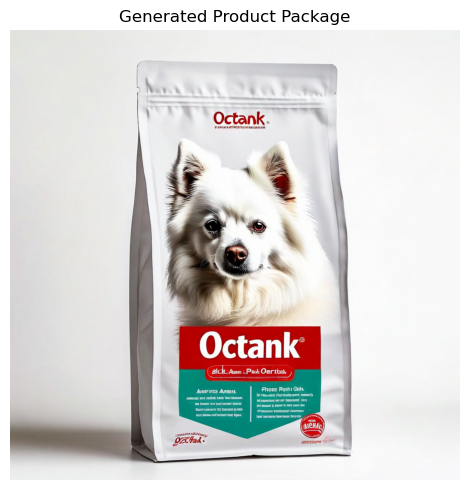

In [5]:
# Generate text-to-image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,                    # Required
            "negativeText": negative_prompts   # Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # Range: 1 to 5 
            "quality": "standard",  # Options: standard or premium
            "height": 1024,        
            "width": 1024,         
            "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
            "seed": 250 #100            # Range: 0 to 214783647
        }
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# save output
save_image(response_body.get("images")[0], output_save_path)

# Plot output
plot_images(response_images, processed_title="Generated Product Package") 

### 2.2 Example: Image Conditioning

#### Scenario
Octank wants to create a oil-painting version of their package design while maintaining the overall layout.

#### Parameters

1. **prompt**: Describes the desired style
2. **reference_image_path**: Path to the original package design
3. **controlMode**: Specifies the conditioning mode (CANNY_EDGE or SEGMENTATION)

In [6]:
# Define the prompt, reference image
prompt = "a oil-painting dog food packet with a white american eskimo on the packet cover, dog food company name is Octank"
reference_image_path = "images/after_text-to-image.png"
seed = 42# Can be any random number between 0 to 214783647

# Specify path to store the output
output_save_path = "images/after_image_cartooning.png" 

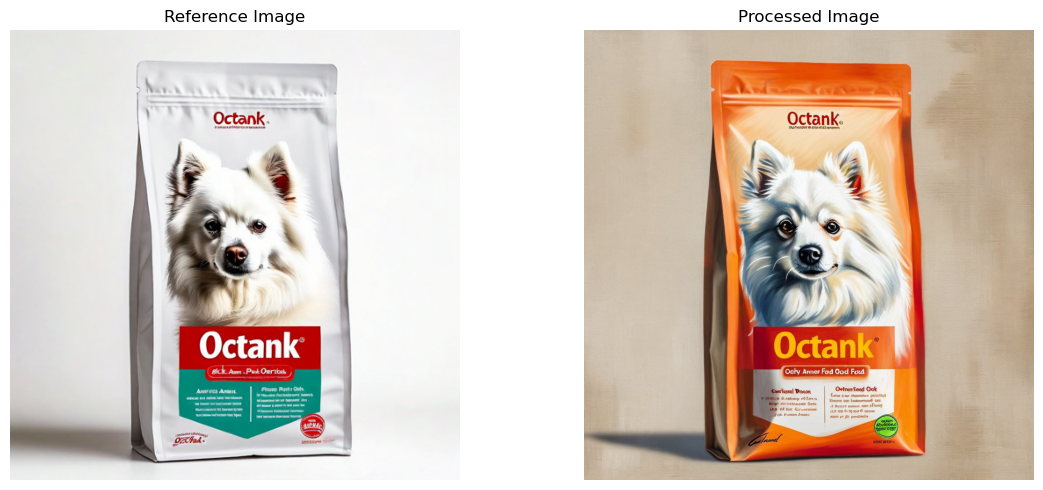

In [7]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,  # Required
            "conditionImage": reference_image_base64, # Optional
            "controlMode": "CANNY_EDGE", # Optional: CANNY_EDGE | SEGMENTATION
            "controlStrength": 0.7,  # Range: 0.2 to 1.0,
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### 2.3 Example: Image Variation

#### Scenario
Generating images from text is powerful but, in some cases, you will want your model to understand the style from certain image and directly transfer it to your output image. Rather than starting from scratch, image variation features enables us to do style transfer easily.

Now, Octank wants to have a dog food packet with the same style showing in the reference image, let's see how easy this step could be.

#### Parameters

1. **prompt**: Describes the desired output
2. **reference_image_path**: Path to the reference style

In [8]:
# Define the prompt, reference image
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank"
negative_prompt = "bad quality, low resolution"
reference_image_path = "images/sketch_dog.png"
seed = 600 # Can be any random number between 0 to 214783647

# Specify path to store the output
output_save_path = "images/after_image_variation.png" 

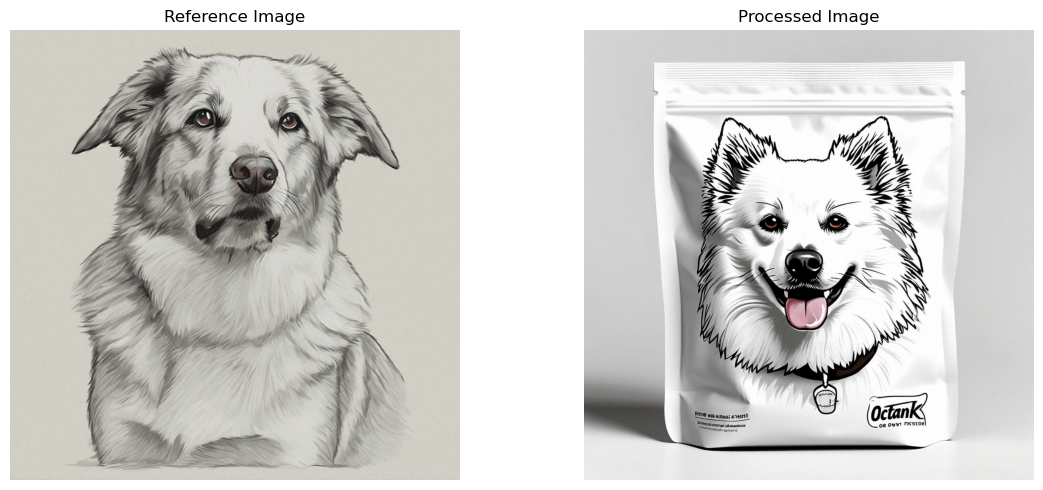

In [9]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

body = json.dumps({
     "taskType": "IMAGE_VARIATION",
     "imageVariationParams": {
         "text": prompt,              # Optional
         "negativeText": negative_prompt,   # Optional
         "images": [reference_image_base64],               # One image is required
        #  "similarityStrength": 1.0
     },
     "imageGenerationConfig": {
         "numberOfImages": 1,
         "quality": "premium",
         "height": 1024,
         "width": 1024,
         #"cfgScale": 10,
         "seed": seed
     }
 })

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### 2.4 Example: Inpainting

#### Scenario
Octank has decided to refresh their product line by featuring different dog breeds on their packaging. However, they want to maintain consistency in the overall design and only change the dog image. This is where inpainting comes in handy. For this task, Octank wants to replace the American Eskimo dog on their current packaging with a Husky, while keeping the rest of the design intact.

Let's use inpainting to help Octank update their packaging with a new dog breed.

#### Parameters

1. **prompt**: Describes the desired output
2. **reference_image_path**: Path to the reference style
3. **mask_prompt**: Describe the object to be replaced

In [10]:
# Define the prompt and reference image
prompt = "A white packet of premium dog food with Husky dog on it, professional product photography. Dog food is named Octank"
negative_prompts = "bad quality, low res"
reference_image_path = "images/after_image_cartooning.png" 
mask_prompt = "American Eskimo dog"
seed = 2 # Can be any random number between 0 to 214783647

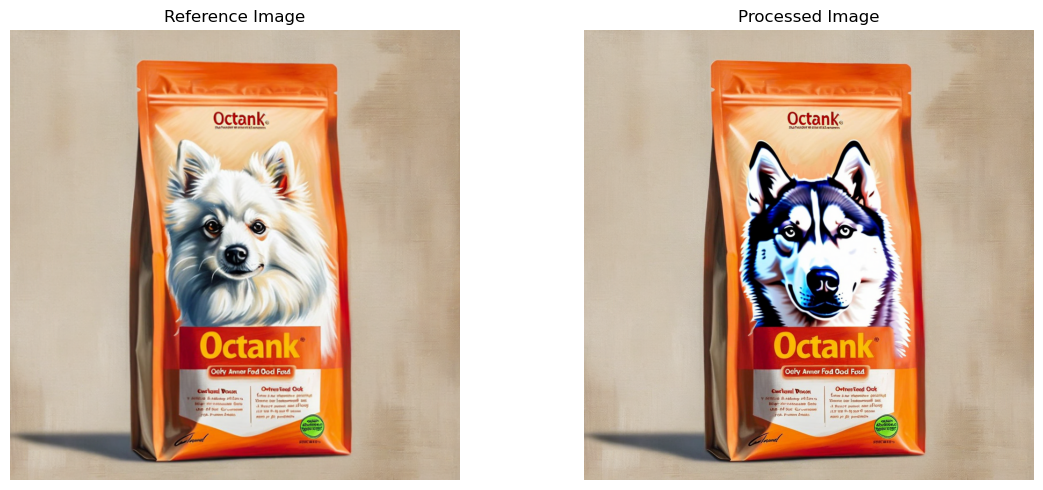

In [11]:
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "INPAINTING",
        "inPaintingParams": {
            "text": prompt,  # Optional - what to change inside the mask
            "negativeText": negative_prompts,    # Optional
            "image": reference_image_base64,  # Required
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            # "maskImage": "base64-encoded string",   

        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### 2.5 Example: Color Conditioning

#### Scenario
Now, let's create a special promotional package design using Octank's brand color palette.

#### Parameters

1. **prompt**: Describes the desired output
2. **hex_color_code**: Provide reference hex color codes

In [12]:
# Define the prompt, reference image, color code and path to store the generated images
prompt = "A white packet of premium dog food with an American Eskimo dog on it, professional product photography. Dog food is named Octank."
hex_color_code = ["#81FC81", "#C9D688", "#FFFFFF"]
seed = 42 # Can be any random number between 0 to 214783647

output_save_path = "images/after_color_conditioning.png"

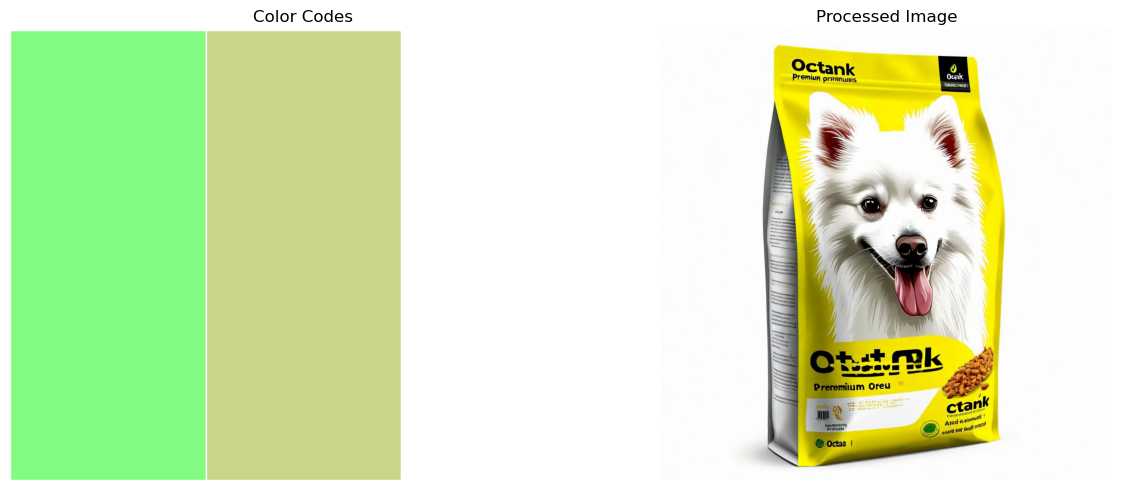

In [13]:
# Encode the reference image
with open(reference_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    
    
# Generate image condition on color palette
body = json.dumps({
    "taskType": "COLOR_GUIDED_GENERATION",
    "colorGuidedGenerationParams": {
        "text": prompt,
        "colors": hex_color_code,
    },
    "imageGenerationConfig": {
        "numberOfImages": 1,
        "seed": seed,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)

# plot output
plot_images(response_images, color_codes = hex_color_code)

### 2.6 Example: Outpainting

#### Scenario
Now, Octank wants to create a professional-looking ad with this new product with kitchen background. To do this kind of background replacement, we will use the outpainting feature offered by Nova Canvas models. 

We will first expand the image size to provide more room, then generating the new image using outpainting feature.

#### Parameters

1. **prompt**: Describes the desired output
2. **reference_image_path**: Path to image that will be edit
3. **mask_prompt**: Describe the area on the image that will not be edited

In [ ]:
# Define the prompt and reference image
prompt = "Dog food packet on a kitchen countertop"
reference_image_path = "images/after_color_conditioning.png" 
mask_prompt = "Dog food packet"
seed = 100 # Can be any random number between 0 to 214783647

# Expansion setting
target_width = 2048
target_height = 2048
horizontal_position_percent=0.3
vertical_position_percent=0.5

output_save_path = "images/after_outpainting.png" 

# Specify path to store the output
expand_image_path = "images/expanded_image.png"

In [ ]:
# Load reference image
original_image = Image.open(reference_image_path)
original_width, original_height = original_image.size

# Calculate the position of the original image on the expanded canvas.
position = (
    int((target_width - original_width) * horizontal_position_percent),
    int((target_height - original_height) * vertical_position_percent),
)

# Create an input image which contains the original image with an expanded
# canvas.
input_image = Image.new("RGB", (target_width, target_height), (235, 235, 235))
input_image.paste(original_image, position)
input_image.save(expand_image_path)
    
# Encode the reference image
with open(expand_image_path, "rb") as image_file:
    reference_image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    
# Generate image condition on reference image
body = json.dumps(
    {
        "taskType": "OUTPAINTING",
        "outPaintingParams": {
            "text": prompt,  # Required
            "image": reference_image_base64,  # Required
            "maskPrompt": mask_prompt,  # One of "maskImage" or "maskPrompt" is required
            "outPaintingMode": "PRECISE",  # One of "PRECISE" or "DEFAULT"
        },
        "imageGenerationConfig": {
                "numberOfImages": 1,
                "seed": seed,
            }
        
    }
)

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

save_image(response_body.get("images")[0], output_save_path)


# plot output
plot_images(response_images, ref_image_path = reference_image_path)

### 2.7 Example: Background Removal

#### Scenario
Octank has professional photos of their existing gourmet dog food. They want to use these images across various marketing materials with different background. In our last use case, we will use Background Removal feature from Amazon Nova Canvas to help Ocktank isolate its product image from their original backgrond.

To use this feature, you just need to provide the image the model needs to work with. 

In [ ]:
# Define image needs to be processed and path to store the generated images
reference_image_path = "images/after_outpainting.png" 

In [ ]:
# Read image from file and encode it as base64 string.
with open(reference_image_path, "rb") as image_file:
    input_image = base64.b64encode(image_file.read()).decode('utf8')

body = json.dumps({
    "taskType": "BACKGROUND_REMOVAL",
    "backgroundRemovalParams": {
        "image": input_image,
    }
})

response = boto3_bedrock.invoke_model(
    body=body, 
    modelId="amazon.nova-canvas-v1:0",
    accept="application/json", 
    contentType="application/json"
)

response_body = json.loads(response.get("body").read())
response_images = [
    Image.open(io.BytesIO(base64.b64decode(base64_image)))
    for base64_image in response_body.get("images")
]

# plot output
plot_images(response_images, ref_image_path= reference_image_path, original_title='Original Image', processed_title='Processed Image without Background')

## 3. Responsible AI in Action

To continue supporting best practices in the responsible use of AI, Amazon Nova Canvas has built to detect and remove harmful content in the data, reject inappropriate content in the user input, and filter the models’ outputs that contain inappropriate content (such as hate speech, profanity, and violence). 

Octank marketing team wants generate an appealing campaign by placing and image of Scooby Doo on the package. 

In [ ]:
# Define the prompt with some inputs blocked for being copyright image.
prompt = "A white packet of premium dog food with Scooby Doo on it, professional product photography. Dog food is named Octank."
negative_prompts = "poorly rendered, poor background details, poor packet details, poor text details, bleary text"
seed = 42

In [ ]:
# Generate text-to-image
body = json.dumps(
    {
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {
            "text": prompt,                    # Required
            "negativeText": negative_prompts   # Optional
        },
        "imageGenerationConfig": {
            "numberOfImages": 1,   # Range: 1 to 5 
            "quality": "standard",  # Options: standard or premium
            "height": 1024,       
            "width": 1024,         
            "cfgScale": 7.5,       # Range: 1.0 (exclusive) to 10.0
            "seed": 42             # Range: 0 to 214783647
        }
    }
)

try:
    response = boto3_bedrock.invoke_model(
        body=body, 
        modelId="amazon.nova-canvas-v1:0",
        accept="application/json", 
        contentType="application/json"
    )
    response_body = json.loads(response.get("body").read())
    response_images = [
        Image.open(io.BytesIO(base64.b64decode(base64_image)))
        for base64_image in response_body.get("images")
    ]

    # Plot output
    plot_images(response_images, processed_title="Generated Product Package")     

# Handle ValidationException (Responsible AI)
except boto3_bedrock.exceptions.ValidationException as error:
    print(f"An error occurred: {error}")

# Handle all the other errors
except Exception as e:
    # Handle any other unexpected exceptions
    print(f"An unexpected error occurred: {e}")


**Note that:** Amazon Bedrock gives validation error as the input prompt is asking for images of Scooby Dog and hence violates copyright.

## 4. Summary and Next Steps

In this notebook lab, we explored the powerful features of Amazon Nova Cnavas through the lens of Octank, a premium dog food company. We covered:

- Text to Image
- Image Conditioning
- Color Variation
- Inpainting
- Color Conditioning
- Outpainting
- Background Removal
- Responsible AI in action

These tools enable Octank to efficiently create diverse, high-quality visuals for their marketing campaigns, maintaining brand consistency while adapting to various styles.

You can now leverage this GenAI-powered image generation to enhance your own creative workflows!

### Next Steps

If you want to know more about video generation, please head to the next notebook lab to explore how to create video contents for Octank Dog Food company!

&nbsp; **NEXT ▶** [3_nova-reel-lab.ipynb](./3\_nova-reel-lab.ipynb).